In [1]:
import sys
sys.path.append("../../src")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import pickle
from example_pendulum import load_pendulum_data
from scipy.integrate import odeint
from autoencoder_pendulum_masked import full_network
from training_pendulum import create_feed_dictionary
from sindy_utils import sindy_simulate_order2
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages

In [2]:
data_path = os.getcwd() + '/'
save_name = 'model17'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

In [3]:
tensorflow_run_tuple

(<tf.Tensor 'coefficient_mask:0' shape=(11, 1) dtype=float32>,
 <tf.Tensor 'x:0' shape=(?, 648) dtype=float32>,
 <tf.Tensor 'dx:0' shape=(?, 648) dtype=float32>,
 <tf.Tensor 'add_3:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'MatMul_17:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'add_7:0' shape=(?, 648) dtype=float32>,
 <tf.Tensor 'MatMul_29:0' shape=(?, 648) dtype=float32>,
 [<tf.Tensor 'gradients/MatMul_4_grad/MatMul:0' shape=(?, 1) dtype=float32>],
 [<tf.Variable 'encoder_W0:0' shape=(648, 64) dtype=float32_ref>,
  <tf.Variable 'encoder_W1:0' shape=(64, 32) dtype=float32_ref>,
  <tf.Variable 'encoder_W2:0' shape=(32, 16) dtype=float32_ref>,
  <tf.Variable 'encoder_W3:0' shape=(16, 1) dtype=float32_ref>],
 [<tf.Variable 'encoder_b0:0' shape=(64,) dtype=float32_ref>,
  <tf.Variable 'encoder_b1:0' shape=(32,) dtype=float32_ref>,
  <tf.Variable 'encoder_b2:0' shape=(16,) dtype=float32_ref>,
  <tf.Variable 'encoder_b3:0' shape=(1,) dtype=float32_ref>],
 [<tf.Variable 'decoder_W0:0' shape

# 1. Plot of UQ on coefficients

In [4]:
arr = np.load("save_refinement_17.npy")
arr_truncate = arr[1:-419]
print(arr_truncate[-1])
print(arr_truncate[0])
print(arr_truncate.shape)
arr_mean = np.mean(arr_truncate, axis=0)
arr_std = np.std(arr_truncate, axis=0)
arr_min = np.min(arr_truncate, axis=0)
arr_max = np.max(arr_truncate, axis=0)
print(arr_mean[9])
print(arr_std[9])

[[ 5.97627461e-03]
 [-7.94506725e-03]
 [-3.32745761e-02]
 [-4.95229103e-03]
 [-1.93672441e-02]
 [ 6.51201000e-03]
 [ 8.61184578e-03]
 [ 9.64761525e-03]
 [-1.04725256e-03]
 [-1.42788353e+01]
 [-1.02157574e-02]]
[[ 1.97356357e-03]
 [ 4.92609246e-03]
 [-9.75445099e-03]
 [-1.53263127e-02]
 [-7.41396891e-03]
 [-1.13074426e-02]
 [ 1.69625431e-02]
 [-8.88209697e-03]
 [-2.19119564e-02]
 [-1.43138819e+01]
 [-1.25630875e-04]]
(100, 11, 1)
[-14.29340455]
[0.01285146]


-0.005424555677802958 0.807527592836613
-14.355538595215508 0.7498701477018482
0.0644877710211996 0.764288395625982
0.12870798367154065 0.7973966072908476
0.09566508420383366 0.8131341671312629
-0.08815368429431324 0.8241188681402066
-0.028305630446047756 0.8523585362220689
-0.03254862597554359 0.7127723047034783
0.05548529534479126 0.798077043315851
-0.09663741442795797 0.9582792773066553
0.005090325816885838 0.9120121199959735


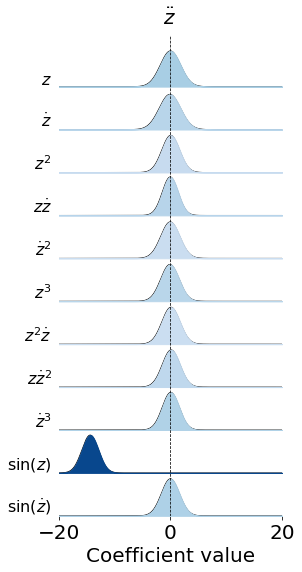

In [114]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

library_names = [r"$z$", r"$\dot{z}$", r"$z^2$", r"$z\dot{z}$", r"$\dot{z}^2$",
                r"$z^3$",r"$z^2\dot{z}$",r"$z\dot{z}^2$",r"$\dot{z}^3$",r"$\sin(z)$",r"$\sin(\dot{z})$",]
library_names.reverse()
def curve(arr):
    n = 1
    center = np.mean(arr)
    scale = np.std(arr)
    print(center, scale)
    X = np.zeros(2000)
    scale *= 2.0
    x = np.linspace(-20, 20, len(X))
    X = 1.0/(scale*np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x - center) / scale)**2)
    return X

cmap = mpl.cm.get_cmap("Blues")
fig = plt.figure(figsize=(8, 8))
arr_truncate = arr_truncate.reshape((100, 11))

ax = None
for n in range(1):
    ax = plt.subplot(1, 2, n + 1, frameon=False, sharex=ax)
    for i in range(len(arr_mean)):
        Y = curve(arr_truncate[:,10-i] + np.random.normal(0, 0.8, 100))
        Y /= (np.max(Y)*0.1 + np.std(Y))/0.1
#         hist, bin_edges = np.histogram(arr_truncate[:,i], density=True)
#         Y = hist/len(arr_truncate[:,i])
        X = np.linspace(-20, 20, len(Y))
        ax.plot(X, 3 * Y + i, color="k", linewidth=0.75, zorder=100 - i)
#         color = cmap(abs(arr_mean[10-i]) / 3.0 + 0.2)
        color = cmap((np.log(abs(arr_mean[10-i])) + 2) / 15.0 + 0.6)
        ax.fill_between(X, 3 * Y + i, i, color=color, zorder=100 - i)

    ax.yaxis.set_tick_params(tick1On=False)
    ax.set_xlim(-20, 20)
    ax.set_ylim(3, 11.2)
    ax.axvline(0.0, ls="--", lw=0.75, color="black", zorder=250)
    ax.text(
        0.465,
        1.06,
        r"$\ddot{z}$",
        ha="left",
        va="top",
        weight="bold",
        transform=ax.transAxes,
    )

    if n == 0:
        ax.yaxis.set_tick_params(labelleft=True)
        ax.set_yticks(np.arange(len(arr_mean)))
#         ax.set_yticklabels(["Serie %d" % i for i in range(1, len(arr_mean)+1)])
        ax.set_yticklabels(library_names)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16)
            tick.label.set_verticalalignment("bottom")
    else:
        ax.yaxis.set_tick_params(labelleft=False)

plt.rcParams.update({'font.size': 20})
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# plt.colorbar(fig, cax=cax)
plt.tight_layout()
plt.xlabel('Coefficient value')
plt.show()

# Learned latent dimension plots

In [3]:
training_data, validation_data = load_pendulum_data()

x,dx,ddx = validation_data['x'], validation_data['dx'], validation_data['ddx']

data_test['x'].shape (8, 648)
data_test['dx'].shape (8, 648)
data_test['ddx'].shape (8, 648)


In [4]:
training_data, validation_data = load_pendulum_data()

x,dx,ddx = training_data['x'], training_data['dx'], training_data['ddx']
x.shape

data_test['x'].shape (8, 648)
data_test['dx'].shape (8, 648)
data_test['ddx'].shape (8, 648)


(382, 648)

In [5]:
test_data = {}
test_data['x'] = x.reshape((-1,params['input_dim']))
test_data['dx'] = dx.reshape((-1,params['input_dim']))
test_data['ddx'] = ddx.reshape((-1,params['input_dim']))
test_data['x'].shape

(382, 648)

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    random_mask = np.random.binomial(1, 1.0, size=(382, 648))
    test_dictionary = create_feed_dictionary(test_data, params,random_mask=random_mask)
    print(tensorflow_run_tuple)
    print(type(tensorflow_run_tuple))
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /home/marsgao/SindyAutoencoders/examples/working_pen_video_real/model17
(<tf.Tensor 'coefficient_mask:0' shape=(11, 1) dtype=float32>, <tf.Tensor 'x:0' shape=(?, 648) dtype=float32>, <tf.Tensor 'dx:0' shape=(?, 648) dtype=float32>, <tf.Tensor 'add_3:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'MatMul_17:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'add_7:0' shape=(?, 648) dtype=float32>, <tf.Tensor 'MatMul_29:0' shape=(?, 648) dtype=float32>, [<tf.Tensor 'gradients/MatMul_4_grad/MatMul:0' shape=(?, 1) dtype=float32>], [<tf.Variable 'encoder_W0:0' shape=(648, 64) dtype=float32_ref>, <tf.Variable 'encoder_W1:0' shape=(64, 32) dtype=float32_ref>, <tf.Variable 'encoder_W2:0' shape=(32, 16) dtype=float32_ref>, <tf.Variable 'encoder_W3:0' shape=(16, 1) dtype=float32_ref>], [<tf.Variable 'encoder_b0:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'encoder_b1:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'encoder_b2:0' shape=(16,) dtype=float32_ref>, <t

In [16]:
test_set_results['sindy_coefficients']

array([[ 1.5016039e-06],
       [ 1.6724239e-06],
       [-6.0618822e-06],
       [ 2.5806632e-06],
       [-4.1080957e-06],
       [-3.6712115e-06],
       [-9.2122509e-06],
       [ 5.9450058e-06],
       [ 3.0704473e-06],
       [-1.4290068e+01],
       [-2.8220486e-06]], dtype=float32)

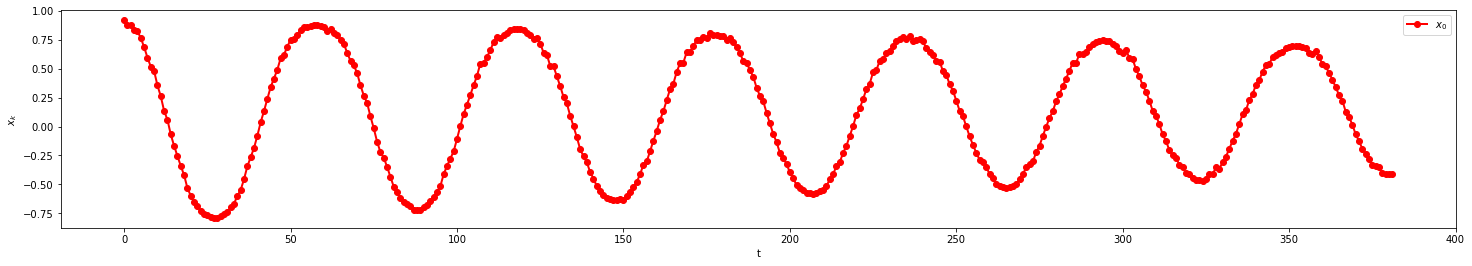

In [17]:
x = np.load("x_gaussian.npy")
dx = np.load("dx_gaussian.npy")
ddx = np.load("ddx_gaussian.npy")

x = x.reshape(790, 27, 24)
dx = dx.reshape(790, 27, 24)
ddx = ddx.reshape(790, 27, 24)

t_train = np.arange(382)
theta_list = []
center = np.array([10.5, 11.5])
for i in range(x.shape[0]):
    active_indices = x[i].T > 0.1
    coordinate_mean = np.zeros((2))
    total_active = np.sum(active_indices)
    for i1 in range(24):
        for j1 in range(27):
            if active_indices[i1,j1] == True:
                coordinate_mean[0] += i1*1.0/total_active
                coordinate_mean[1] += j1*1.0/total_active
    theta = np.arctan((coordinate_mean[0]-center[0]) / (coordinate_mean[1]-center[1]))
    theta_list.append(theta)

theta = np.array(theta_list[:390])
dtheta = np.gradient(theta, 0.034)
ddtheta = np.gradient(dtheta, 0.034)

plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 1, figsize=(25, 4))
axs.plot(t_train, theta_list[:382], "r", label="$x_0$", marker='o', **plot_kws)
axs.legend()
axs.set(xlabel="t", ylabel="$x_k$")

fig.show()

In [18]:
x = np.load("x_gaussian.npy")
dx = np.load("dx_gaussian.npy")
ddx = np.load("ddx_gaussian.npy")

x = x.reshape(790, 27, 24)
dx = dx.reshape(790, 27, 24)
ddx = ddx.reshape(790, 27, 24)

t_train = np.arange(382)
coordinate = np.zeros((790, 2))
center = np.array([10.5, 11.5])
for i in range(x.shape[0]):
    active_indices = x[i].T > 0.1
    coordinate_mean = np.zeros((2))
    total_active = np.sum(active_indices)
    for i1 in range(24):
        for j1 in range(27):
            if active_indices[i1,j1] == True:
                coordinate_mean[0] += i1*1.0/total_active
                coordinate_mean[1] += j1*1.0/total_active
    coordinate[i,0] = coordinate_mean[0]-center[0]
    coordinate[i,1] = coordinate_mean[1]-center[1]




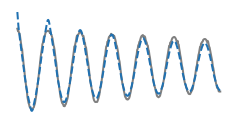

In [175]:
plot_kws = dict(linewidth=2)
t_train = np.linspace(0, 14, 382)
fig, axs = plt.subplots(1, 1, figsize=(4, 2))
axs.plot(t_train, theta_list[:382], "grey", label=r"$\hat\theta$", **plot_kws)
axs.plot(t_train, (test_set_results['z'])/3.5, label="$\hat z$", color='#2071B1', linestyle='dashed', **plot_kws)
# axs.legend()
plt.axis('off')
fig.show()

# UQ plot of prediction trajectory

In [20]:
true_coefficients = np.zeros((12,1))
mask = np.ones(12)
# true_coefficients[1] = 7.7
true_coefficients[-2] = -14.15
t = t_train = np.arange(0, 382*0.034, 0.034)
z_sim = np.zeros((t.size, 2))
pendulum_sim = np.zeros(z_sim.shape)
z_sim = sindy_simulate_order2((test_set_results['z'][0])/4.0, [0.0], t,
                                     true_coefficients,
                                     params['poly_order'], params['include_sine'])


In [95]:
test_set_results['sindy_coefficients'][9][0]

-14.290068

In [160]:
z_sim = np.zeros((t.size, 2))
pendulum_sim = np.zeros(z_sim.shape)
mc_num = 49
mc_z_sim = np.zeros((mc_num, t.size, 2))
true_coefficients = np.zeros((12,1))
true_coefficients[-2] = test_set_results['sindy_coefficients'][9,0]
z_sim = sindy_simulate_order2(test_set_results['z'][0]/3.5, [0.0], t,
                                     true_coefficients,
                                     params['poly_order'], params['include_sine'])
for j in range(mc_num):
    coeff = np.zeros((12,1))
    coeff[-2] = arr_truncate[j*2,9]+np.random.normal(0, 0.8, 1)
#     print(arr_truncate[j*2,9])
    mc_z_sim[j] = sindy_simulate_order2(test_set_results['z'][0]/3.5, [0.0], t,
                                 coeff,
                                 params['poly_order'], params['include_sine'])

/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until


(-0.6477, 13.601700000000001, -3.6688125424753935, 3.64698126459834)

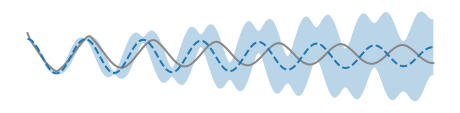

In [183]:
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.plot(t, test_set_results['z'][0:t.size,0]/2.6, 'k', color='#888888', linewidth=2)
plt.plot(t, np.mean(mc_z_sim[:,:,0], axis=0), '--', linewidth=2)
plt.fill_between(t, np.mean(mc_z_sim[:,:,0], axis=0)-3.5*np.std(mc_z_sim[:,:,0], axis=0),
                np.mean(mc_z_sim[:,:,0], axis=0)+3.5*np.std(mc_z_sim[:,:,0], axis=0), alpha=0.3)
# plt.xticks([0, 20, 40, 60, 80, 100])
plt.xticks([])
plt.yticks([])
plt.xlabel('Time')
# plt.figure(figsize=(100,2))
# plt.axes([0, 0.6, 1, 1])
plt.axis('off')

# Fraction of unexplained variance metric

In [184]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_ddx_error = np.mean((test_data['ddx'] - test_set_results['ddx_decode'])**2)/np.mean(test_data['ddx']**2)
sindy_ddz_error = np.mean((test_set_results['ddz'] - test_set_results['ddz_predict'])**2)/np.mean(test_set_results['ddz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_ddx_error)
print('SINDy reltive error, z: %f' % sindy_ddz_error)

Decoder relative error: 0.002909
Decoder relative SINDy error: 0.081119
SINDy reltive error, z: 0.961275


# Example plots of reconstruction

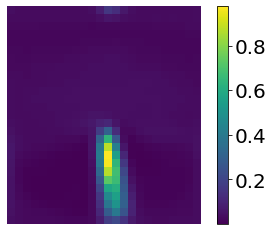

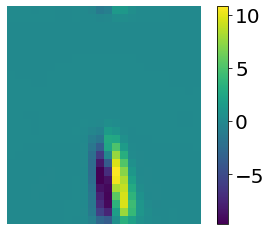

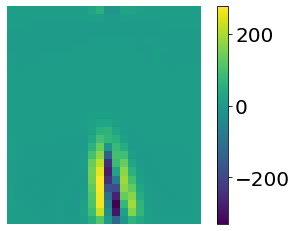

In [210]:
import numpy as np
import matplotlib.pyplot as plt
x_decode = np.load("decode_x.npy")
dx_decode = np.load("dx_decode.npy")
ddx_decode = np.load("ddx_decode.npy")
x_decode = x_decode.reshape(10,27,24)
dx_decode = dx_decode.reshape(10,27,24)
ddx_decode = ddx_decode.reshape(10,27,24)
idx = 0
img = x_decode[idx]
plt.imshow(img, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

img = dx_decode[idx]
plt.imshow(img, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

img = ddx_decode[idx]
plt.imshow(img, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

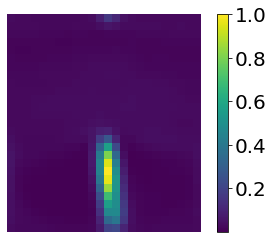

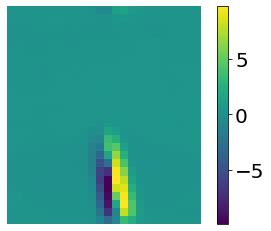

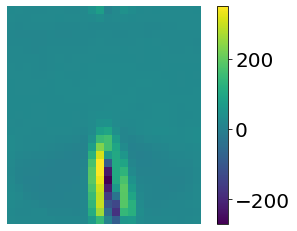

In [223]:
import numpy as np
import matplotlib.pyplot as plt
x_decode = np.load("x_gaussian.npy")
dx_decode = np.load("dx_gaussian.npy")
ddx_decode = np.load("ddx_gaussian.npy")
x_decode = x_decode.reshape(790,27,24)
dx_decode = dx_decode.reshape(790,27,24)
ddx_decode = ddx_decode.reshape(790,27,24)
idx = 306
idx = 280
img = x_decode[idx]
plt.imshow(img, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

img = dx_decode[idx]
plt.imshow(img, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

img = ddx_decode[idx]
plt.imshow(img, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

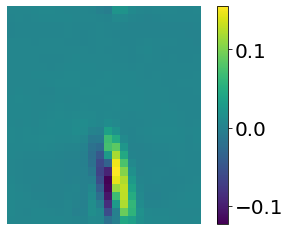

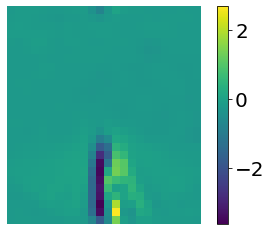

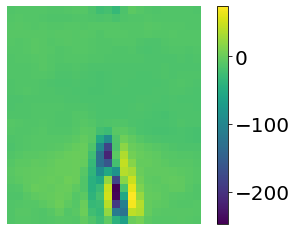

In [224]:
x_decode_hat = np.load("decode_x.npy")
dx_decode_hat = np.load("dx_decode.npy")
ddx_decode_hat = np.load("ddx_decode.npy")
x_decode_hat = x_decode_hat.reshape(10,27,24)
dx_decode_hat = dx_decode_hat.reshape(10,27,24)
ddx_decode_hat = ddx_decode_hat.reshape(10,27,24)
x_decode = np.load("x_gaussian.npy")
dx_decode = np.load("dx_gaussian.npy")
ddx_decode = np.load("ddx_gaussian.npy")
x_decode = x_decode.reshape(790,27,24)
dx_decode = dx_decode.reshape(790,27,24)
ddx_decode = ddx_decode.reshape(790,27,24)

img = x_decode_hat[0]-x_decode[idx]
plt.imshow(img, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

img = dx_decode_hat[0]-dx_decode[idx]
plt.imshow(img, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

img = ddx_decode_hat[0]-ddx_decode[idx]
plt.imshow(img, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

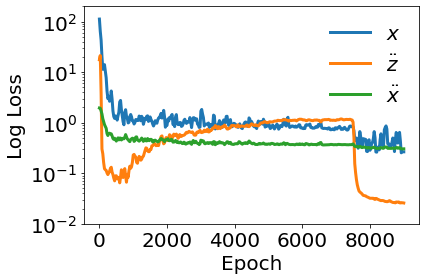

In [364]:
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)
import numpy as np
import matplotlib.pyplot as plt
train_loss = []
test_loss_decoder = []
test_loss_dz = []
test_loss_dx = []
norms = []
file = open('verylongrun.out', 'r') 
Lines = file.readlines() 

# Strips the newline character 
for line in Lines: 
    if "validation loss" in line:
        test_loss_line = line.split(", (")[1]
        decoder_loss = test_loss_line.split(", ")[0]
        dz_loss = test_loss_line.split(", ")[1]
        dx_loss = test_loss_line.split(", ")[2]
        test_loss_decoder.append(float(decoder_loss))
        test_loss_dz.append(float(dz_loss))
        test_loss_dx.append(float(dx_loss))


t = np.arange(0.0, len(train_loss)/8, 1)
n = 8
averages1 = [sum(train_loss[i:i+n])/n for i in range(0,len(train_loss),n)]



t = np.arange(0.0, len(test_loss_decoder)*25, 25)
#         num = 0
window = 1
test_loss_decoder = moving_avg(test_loss_decoder, window+1)     
test_loss_dz = moving_avg(test_loss_dz, window+1)     
test_loss_dx = moving_avg(test_loss_dx, window+1)     
fig, ax = plt.subplots()
ax.plot(t[:-window], test_loss_decoder/(27*24), label=r'$x$', linewidth=3.0)
ax.plot(t[:-window], test_loss_dz, label=r'$\ddot{z}$', linewidth=3.0)
ax.plot(t[:-window], test_loss_dx/(27*24), label=r'$\ddot{x}$', linewidth=3.0)
# ax.axvline(x=7500, ymax = 0.45, color='grey', linestyle='dashed')
# ax.axvline(x=7500, color='grey', linestyle='dashed', label="7500")
ax.set(xlabel='Epoch', ylabel='Log Loss',
       title='')
# ax.grid()
# plt.xlim((0, 0.1))
plt.ylim((0.01, 200))
plt.legend(frameon=False, loc='upper right', ncol=1)
plt.yscale('log')
# plt.xscale('log')
plt.show()



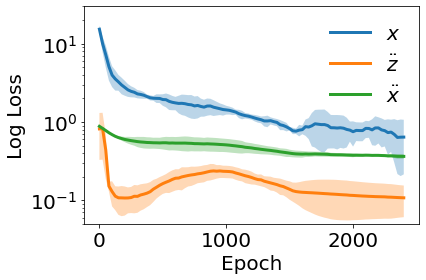

In [368]:
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)
import numpy as np
import matplotlib.pyplot as plt
test_loss_decoder1 = []
test_loss_dz1 = []
test_loss_dx1 = []
test_loss_decoder2 = []
test_loss_dz2 = []
test_loss_dx2 = []
test_loss_decoder3 = []
test_loss_dz3 = []
test_loss_dx3 = []
norms = []
file1 = open('short_run1.out', 'r') 
file2 = open('short_run2.out', 'r') 
file3 = open('short_run3.out', 'r') 
Lines1 = file1.readlines() 
Lines2 = file2.readlines() 
Lines3 = file3.readlines() 

# Strips the newline character 
for line in Lines1: 
    if "validation loss" in line:
        test_loss_line = line.split(", (")[1]
        decoder_loss = test_loss_line.split(", ")[0]
        dz_loss = test_loss_line.split(", ")[1]
        dx_loss = test_loss_line.split(", ")[2]
        test_loss_decoder1.append(float(decoder_loss))
        test_loss_dz1.append(float(dz_loss))
        test_loss_dx1.append(float(dx_loss))

# Strips the newline character 
for line in Lines2: 
    if "validation loss" in line:
        test_loss_line = line.split(", (")[1]
        decoder_loss = test_loss_line.split(", ")[0]
        dz_loss = test_loss_line.split(", ")[1]
        dx_loss = test_loss_line.split(", ")[2]
        test_loss_decoder2.append(float(decoder_loss))
        test_loss_dz2.append(float(dz_loss))
        test_loss_dx2.append(float(dx_loss))
        
# Strips the newline character 
for line in Lines3: 
    if "validation loss" in line:
        test_loss_line = line.split(", (")[1]
        decoder_loss = test_loss_line.split(", ")[0]
        dz_loss = test_loss_line.split(", ")[1]
        dx_loss = test_loss_line.split(", ")[2]
        test_loss_decoder3.append(float(decoder_loss))
        test_loss_dz3.append(float(dz_loss))
        test_loss_dx3.append(float(dx_loss))
t = np.arange(0.0, len(train_loss)/8, 1)
n = 8
averages1 = [sum(train_loss[i:i+n])/n for i in range(0,len(train_loss),n)]

t = np.arange(0.0, len(test_loss_decoder1)*25, 25)
#         num = 0
window = 25
test_loss_decoder1 = moving_avg(test_loss_decoder1, window+1)     
test_loss_dz1 = moving_avg(test_loss_dz1, window+1)     
test_loss_dx1 = moving_avg(test_loss_dx1, window+1)   
test_loss_decoder2 = moving_avg(test_loss_decoder2, window+1)     
test_loss_dz2 = moving_avg(test_loss_dz2, window+1)     
test_loss_dx2 = moving_avg(test_loss_dx2, window+1)   
test_loss_decoder3 = moving_avg(test_loss_decoder3, window+1)     
test_loss_dz3 = moving_avg(test_loss_dz3, window+1)     
test_loss_dx3 = moving_avg(test_loss_dx3, window+1)   

test_loss_decoders = np.array([test_loss_decoder1, test_loss_decoder2, test_loss_decoder3])
test_loss_dzs = np.array([test_loss_dz1, test_loss_dz2, test_loss_dz3])
test_loss_dxs = np.array([test_loss_dx1, test_loss_dx2, test_loss_dx3])

fig, ax = plt.subplots()
ax.plot(t[:-(window)], np.mean(test_loss_decoders, axis=0)/(27*24), label=r'$x$', linewidth=3.0)
ax.fill_between(t[:-(window)], np.mean(test_loss_decoders, axis=0)/(27*24)-2*np.std(test_loss_decoders/(27*24), axis=0), np.mean(test_loss_decoders, axis=0)/(27*24)+2*np.std(test_loss_decoders/(27*24), axis=0), alpha=0.3)
ax.plot(t[:-(window)], np.mean(test_loss_dzs, axis=0), label=r'$\ddot{z}$', linewidth=3.0)
ax.fill_between(t[:-(window)], np.mean(test_loss_dzs, axis=0)-2*np.std(test_loss_dzs, axis=0), np.mean(test_loss_dzs, axis=0)+2*np.std(test_loss_dzs, axis=0), alpha=0.3)
ax.plot(t[:-(window)], np.mean(test_loss_dxs/(27*24), axis=0), label=r'$\ddot{x}$', linewidth=3.0)
ax.fill_between(t[:-(window)], np.mean(test_loss_dxs, axis=0)/(27*24)-2*np.std(test_loss_dxs/(27*24), axis=0), np.mean(test_loss_dxs, axis=0)/(27*24)+2*np.std(test_loss_dxs/(27*24), axis=0), alpha=0.3)
# ax.axvline(x=7500, color='grey', linestyle='dashed', label="7500")
ax.set(xlabel='Epoch', ylabel='Log Loss',
       title='')
# ax.grid()
# plt.xlim((0, 0.1))
plt.ylim((0.05, 30))
plt.legend(frameon=False, loc='upper right', ncol=1)
plt.yscale('log')
# plt.xscale('log')
plt.show()



# Prediction of the next 10 frames

In [369]:
test_set_results

{'coefficient_mask': array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]], dtype=float32),
 'x': array([[0.02637863, 0.02136229, 0.01957466, ..., 0.02672006, 0.02650285,
         0.02490466],
        [0.03030558, 0.0253776 , 0.02314962, ..., 0.03019339, 0.02969944,
         0.0279272 ],
        [0.02921206, 0.02432905, 0.02237514, ..., 0.0275798 , 0.02753379,
         0.02598271],
        ...,
        [0.03857641, 0.0306646 , 0.03830308, ..., 0.02694975, 0.02650288,
         0.02760389],
        [0.03363036, 0.0263145 , 0.03534563, ..., 0.02092697, 0.02083163,
         0.0220015 ],
        [0.0374389 , 0.03052724, 0.03990402, ..., 0.02494308, 0.02459249,
         0.02604745]], dtype=float32),
 'dx': array([[ 0.11769076,  0.12033908,  0.10714171, ...,  0.10409572,
          0.09580176,  0.09058557],
        [-0.03277285, -0.03142509, -0.02321122, ..., -0.07832947,
         -0.06490449, -0

In [508]:
import math

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def decoder(output):
    for i in range(3):
        output = np.matmul(output, test_set_results['decoder_weights'][i]) + test_set_results['decoder_biases'][i]
        output = sigmoid(output)
    output = np.matmul(output, test_set_results['decoder_weights'][3]) + test_set_results['decoder_biases'][3]
    return output

In [509]:
output.shape

(1, 648)

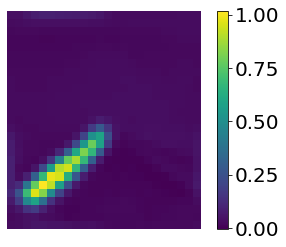

In [513]:

output = decoder([-1.5])



img = output.reshape(27, 24)
plt.imshow(img, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

In [429]:
mc_z_sim

array([[[ 1.27056611,  0.        ],
        [ 1.26250336, -0.47408089],
        [ 1.23835637, -0.94570293],
        ...,
        [ 1.20459296, -1.34952117],
        [ 1.15087715, -1.80853223],
        [ 1.08175454, -2.25499562]],

       [[ 1.27056611,  0.        ],
        [ 1.26233816, -0.48379035],
        [ 1.23769729, -0.96501812],
        ...,
        [ 0.91363696, -3.06529546],
        [ 0.80278992, -3.4490016 ],
        [ 0.67957313, -3.79137148]],

       [[ 1.27056611,  0.        ],
        [ 1.26314299, -0.43648597],
        [ 1.24090854, -0.87089384],
        ...,
        [ 0.14589709,  4.31947783],
        [ 0.29125683,  4.22028334],
        [ 0.43216517,  4.05840193]],

       ...,

       [[ 1.27056611,  0.        ],
        [ 1.26278416, -0.45757684],
        [ 1.23947671, -0.91286606],
        ...,
        [ 1.15508649,  1.74595029],
        [ 1.20693411,  1.30233897],
        [ 1.24355944,  0.85110268]],

       [[ 1.27056611,  0.        ],
        [ 1.2626129 , -0.46

In [515]:
mc_theta_sim = np.zeros((49, 382))
mc_video_pred = np.zeros((49, 382, 648))

In [498]:
def simplePendulumSimulation(theta0,omega0,tau=0.034,m=1.0,g=-14.2,l=1.0,numSteps=382,plotFlag=True):
    # initialize vectors
    time_vec = [0]*numSteps
    theta_vec = [0]*numSteps
    omega_vec = [0]*numSteps
 
    # set initial conditions
 
    theta = theta0
    omega = omega0
    time = 0
    # begin time-stepping
 
    for i in range(0,numSteps):
        omega_old = omega
        theta_old = theta
        # update the values
        omega = omega_old - (g/l)*np.sin(theta_old)*tau
        theta = theta_old + omega*tau
        # record the values
        time_vec[i] = tau*i
        theta_vec[i] = theta
        omega_vec[i] = omega
    return theta_vec


In [499]:
thetas = simplePendulumSimulation((test_set_results['z'][0])/3.5, 0.0)

In [530]:
mc_theta_sim = np.zeros((49, 382))
coef = -14.2
for i in range(49):
    init_cond = (test_set_results['z'])/3.5
    g = arr_truncate[i*2,9]+np.random.normal(0, 0.8, 1)
    thetas = simplePendulumSimulation((test_set_results['z'][0])/3.5, 0.0, g=g)
    mc_theta_sim[i] = np.array(thetas).reshape(382,)
        

In [531]:
mc_theta_sim

array([[1.28616701, 1.31744226, 1.36452759, ..., 1.38732217, 1.4567054 ,
        1.54231389],
       [1.28653637, 1.31855382, 1.36676032, ..., 1.82436879, 1.96784112,
        2.126731  ],
       [1.28625691, 1.31771281, 1.36507102, ..., 1.46407543, 1.5514956 ,
        1.65533826],
       ...,
       [1.284996  , 1.31391876, 1.35745147, ..., 2.17174928, 2.01664842,
        1.87517649],
       [1.28680515, 1.31936274, 1.36838526, ..., 2.33364816, 2.52292713,
        2.7220649 ],
       [1.28641173, 1.31817873, 1.36600687, ..., 1.64109093, 1.75983452,
        1.89487022]])

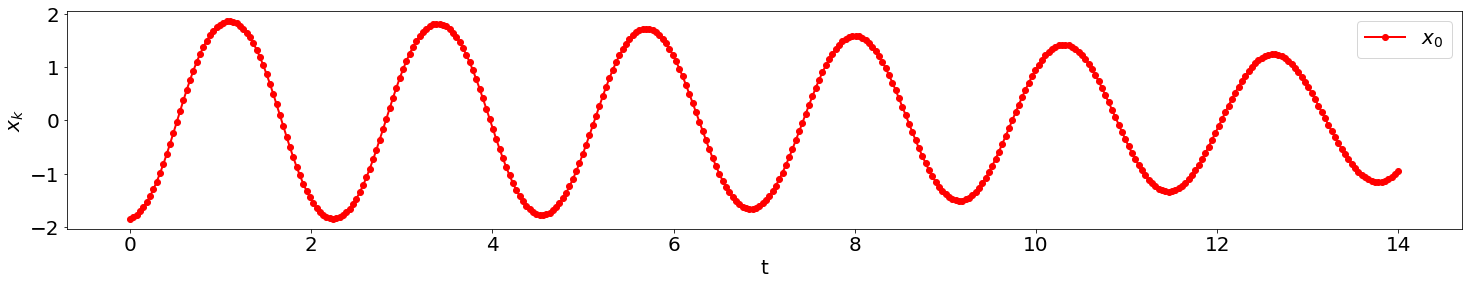

In [551]:
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 1, figsize=(25, 4))
axs.plot(t_train, np.mean(mc_theta_sim, axis=0)-3.14, "r", label="$x_0$", marker='o', **plot_kws)
axs.legend()
axs.set(xlabel="t", ylabel="$x_k$")

fig.show()

In [553]:
mc_theta_sim -= 3.1415926

In [554]:
# mc_video_pred
for i in range(49):
    for j in range(382):
        mc_video_pred[i,j] = decoder([mc_theta_sim[i,j]])

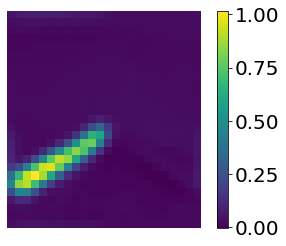

In [555]:
img = mc_video_pred[10,0,:].reshape(27, 24)
plt.imshow(img, interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()

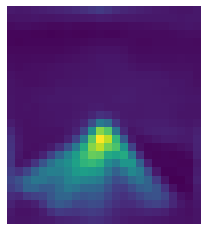

In [574]:
averaged_video_pred = np.zeros((382, 648))
for i in range(382):
    for j in range(49):
        averaged_video_pred[i] += (1/49.0) * mc_video_pred[j,i,:]
img = averaged_video_pred[360].reshape(27, 24)
plt.imshow(img, interpolation='nearest')
# plt.colorbar()
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.show()